In [5]:
import numpy as np
import matplotlib.pyplot as plt

class MazeGame:
    def __init__(self):
        maze_layout = [
            [1, 1, 1, 1, 1, 1, 1],
            [1, 0, 0, 0, 0, 0, 1],
            [1, 0, 1, 1, 1, 0, 1],
            [1, 0, 1, 0, 0, 0, 1],
            [1, 0, 1, 1, 1, 1, 1],
            [1, 0, 0, 0, 0, 0, 0],
            [1, 1, 1, 1, 1, 1, 1]
        ]
        self.layout = np.array(maze_layout)
        self.rgb_maze = self._to_rgb()
        self.start_pos = None
        self.exit_pos = None
        self.current_pos = None

    def _to_rgb(self):
        """Convert the maze layout to an RGB image."""
        rgb = np.zeros((*self.layout.shape, 3))  # Create a new RGB array
        for i in range(3):  # Copy the grayscale values into each RGB channel
            rgb[:, :, i] = 1 - self.layout
        return rgb

    def initialPosition(self, row, col):
        """Set the initial position in the maze."""
        if self.layout[row, col] == 0:
            self.start_pos = (row, col)
            self.current_pos = (row, col)
            self.set_point(row, col, [0, 0, 1])  # Mark initial position with blue
        else:
            print("Invalid initial position: It is on a wall.")

    def setExit(self, row, col):
        """Set the exit position in the maze."""
        if self.layout[row, col] == 0:
            self.exit_pos = (row, col)
            self.set_point(row, col, [0, 1, 0])  # Mark exit position with green
        else:
            print("Invalid exit position: It is on a wall.")

    def set_point(self, row, col, color):
        """Set a specific point in the maze to a given color."""
        self.rgb_maze[row, col] = color

    def makeMove(self, direction):
        """Attempt to move in the specified direction."""
        if self.current_pos is None:
            print("Initial position not set.")
            return 0

        row, col = self.current_pos
        if direction == "up":
            new_pos = (row - 1, col)
        elif direction == "down":
            new_pos = (row + 1, col)
        elif direction == "left":
            new_pos = (row, col - 1)
        elif direction == "right":
            new_pos = (row, col + 1)
        else:
            print("Invalid direction.")
            return 0

        if self.isValidMove(new_pos):
            self.set_point(*self.current_pos, [1, 1, 0])  # Mark path with yellow
            self.current_pos = new_pos
            if self.current_pos == self.exit_pos:
                self.set_point(*self.current_pos, [0, 1, 0])  # Mark exit position with green if it's the exit
                print("Success! You've found the way out.")
                return 1
            self.set_point(*self.current_pos, [0, 0, 1])  # Mark new position with blue
        else:
            print("Invalid move: Can't move through walls or out of bounds.")
        return 0

    def isValidMove(self, pos):
        """Check if a move is valid (within bounds and not through walls)."""
        row, col = pos
        if 0 <= row < self.layout.shape[0] and 0 <= col < self.layout.shape[1]:
            return self.layout[row, col] == 0
        return False

    def plot(self):
        """Plot the maze."""
        plt.figure(figsize=(7, 7))
        plt.imshow(self.rgb_maze, interpolation='nearest')
        plt.xticks([]), plt.yticks([])  # Hide axes ticks
        plt.show()

# Assuming the ModelBasedAgent class and policy running code are correctly set up and integrated with the above code.
class ModelBasedAgent:
    def __init__(self, game, gamma=0.99):
        self.game = game
        self.gamma = gamma  # Discount factor
        # Initialize the value function for all states to zero
        self.values = np.zeros(game.layout.shape)
        self.policy = np.full(game.layout.shape, 'hold', dtype=object)
        self.actions = ['up', 'down', 'left', 'right']

    def update_values(self, iterations=100):
        for _ in range(iterations):
            new_values = np.copy(self.values)
            for row in range(self.game.layout.shape[0]):
                for col in range(self.game.layout.shape[1]):
                    if self.game.layout[row, col] == 0:  # Only update for navigable cells
                        state_value = []
                        for action in self.actions:
                            new_pos = self.predict_move((row, col), action)
                            reward = self.predict_reward((row, col), new_pos)
                            state_value.append(reward + self.gamma * self.values[new_pos])
                        best_action_value = max(state_value)
                        new_values[row, col] = best_action_value
                        self.policy[row, col] = self.actions[state_value.index(best_action_value)]
            self.values = new_values

    def predict_move(self, pos, action):
        if action == "up":
            new_pos = (max(0, pos[0]-1), pos[1])
        elif action == "down":
            new_pos = (min(self.game.layout.shape[0]-1, pos[0]+1), pos[1])
        elif action == "left":
            new_pos = (pos[0], max(0, pos[1]-1))
        elif action == "right":
            new_pos = (pos[0], min(self.game.layout.shape[1]-1, pos[1]+1))
        return new_pos if self.game.layout[new_pos] == 0 else pos

    def predict_reward(self, pos, new_pos):
        if new_pos == self.game.exit_pos:
            return 100  # Large reward for reaching the exit
        elif new_pos == pos:
            return -5  # Penalty for hitting a wall
        else:
            return -1  # Small penalty for each move to encourage shortest path

    def run_policy(self):
        print("Running policy...")
        current_pos = self.game.current_pos
        steps = 0
        while current_pos != self.game.exit_pos:
            action = self.policy[current_pos]
            print(f"Step {steps}: at {current_pos} taking action {action}")
            self.game.makeMove(action)
            current_pos = self.game.current_pos
            steps += 1
            if steps > 50:  # Just in case something goes wrong
                print("Something went wrong. Stopping after 50 steps.")
                break

    def update_game(self, new_game):
        self.game = new_game

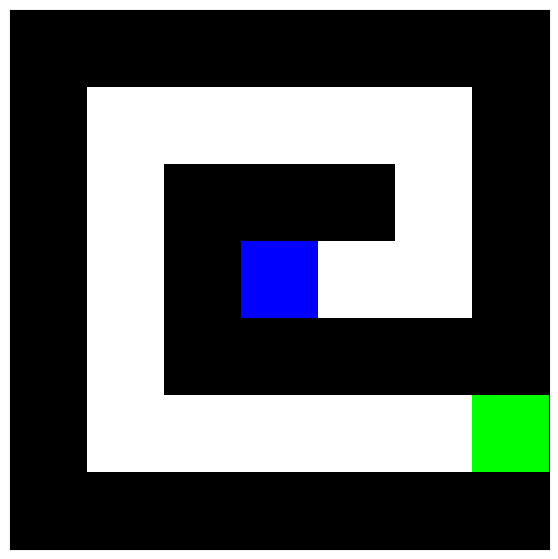

In [6]:
# Create an instance of MazeGame
maze_game = MazeGame()

# Set the initial and exit positions
maze_game.initialPosition(3, 3)
maze_game.setExit(5, 6)
maze_game.plot()

In [7]:
# Initialize the model-based agent with the maze game and update its values
model_based_agent = ModelBasedAgent(maze_game)
model_based_agent.update_values(100)  # Perform value iteration

# Now, run the agent's policy to see how it navigates the maze
model_based_agent.run_policy()

Running policy...
Step 0: at (3, 3) taking action right
Step 1: at (3, 4) taking action right
Step 2: at (3, 5) taking action up
Step 3: at (2, 5) taking action up
Step 4: at (1, 5) taking action left
Step 5: at (1, 4) taking action left
Step 6: at (1, 3) taking action left
Step 7: at (1, 2) taking action left
Step 8: at (1, 1) taking action down
Step 9: at (2, 1) taking action down
Step 10: at (3, 1) taking action down
Step 11: at (4, 1) taking action down
Step 12: at (5, 1) taking action right
Step 13: at (5, 2) taking action right
Step 14: at (5, 3) taking action right
Step 15: at (5, 4) taking action right
Step 16: at (5, 5) taking action right
Success! You've found the way out.


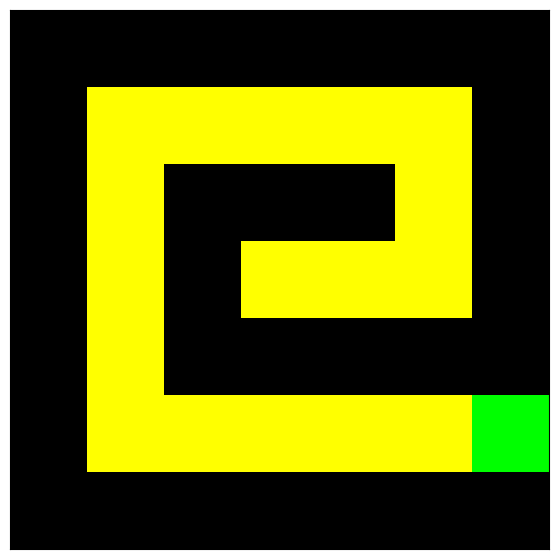

In [8]:
maze_game.plot()

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

class MazeGame:
    def __init__(self):
        maze_layout = [
            [1, 1, 1, 1, 1, 1, 1],
            [1, 0, 0, 0, 0, 0, 1],
            [1, 0, 1, 1, 1, 0, 1],
            [1, 0, 1, 0, 0, 0, 1],
            [1, 0, 1, 1, 1, 1, 1],
            [1, 0, 0, 0, 0, 0, 0],
            [1, 1, 1, 1, 1, 1, 1]
        ]
        self.layout = np.array(maze_layout)
        self.rgb_maze = self._to_rgb()
        self.start_pos = None
        self.exit_pos = None
        self.current_pos = None

    def _to_rgb(self):
        rgb = np.zeros((*self.layout.shape, 3))
        for i in range(3):
            rgb[:, :, i] = 1 - self.layout
        return rgb

    def set_point(self, row, col, color, intensity=1):
        self.rgb_maze[row, col] = [color[0] * intensity, color[1], color[2]]

    def find_path(self):
        queue = deque([(self.exit_pos, 0)])
        visited = set([self.exit_pos])
        path = {}
        while queue:
            (current, depth), queue = queue.popleft(), queue
            for direction in [(0, 1), (1, 0), (0, -1), (-1, 0)]:
                neighbor = (current[0] + direction[0], current[1] + direction[1])
                if neighbor in visited or not self.isValidMove(neighbor):
                    continue
                queue.append((neighbor, depth + 1))
                visited.add(neighbor)
                path[neighbor] = (current, depth + 1)
                if neighbor == self.start_pos:
                    return path, depth + 1
        return path, None

    def apply_gradient(self):
        path, max_depth = self.find_path()
        if max_depth is None:
            return
        position = self.start_pos
        while position != self.exit_pos:
            prev_position, depth = path[position]
            intensity = 1 - depth / max_depth
            self.set_point(*position, [1, 0, 0], intensity)
            position = prev_position
        # Set exit position with full intensity red
        self.set_point(*self.exit_pos, [1, 0, 0], 1)

    def isValidMove(self, pos):
        row, col = pos
        if 0 <= row < self.layout.shape[0] and 0 <= col < self.layout.shape[1]:
            return self.layout[row, col] == 0
        return False

    def plot(self):
        plt.figure(figsize=(7, 7))
        plt.imshow(self.rgb_maze, interpolation='nearest')
        plt.xticks([]), plt.yticks([])  # Hide axes ticks
        plt.show()

# Example usage
game = MazeGame()
game.initialPosition(5, 5)  # Set initial position; adjust accordingly
game.setExit(1, 1)          # Set exit position; adjust accordingly
game.apply_gradient()       # Apply the gradient from the exit to the initial position
game.plot()                 # Display the maze with the gradient path


AttributeError: 'MazeGame' object has no attribute 'initialPosition'

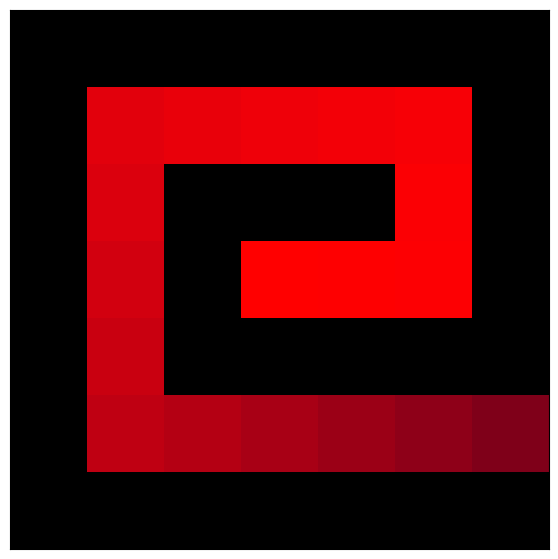

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

class MazeGame:
    def __init__(self):
        maze_layout = [
            [1, 1, 1, 1, 1, 1, 1],
            [1, 0, 0, 0, 0, 0, 1],
            [1, 0, 1, 1, 1, 0, 1],
            [1, 0, 1, 0, 0, 0, 1],
            [1, 0, 1, 1, 1, 1, 1],
            [1, 0, 0, 0, 0, 0, 0],
            [1, 1, 1, 1, 1, 1, 1]
        ]
        self.layout = np.array(maze_layout)
        self.rgb_maze = self._to_rgb()
        self.start_pos = None
        self.exit_pos = None
        self.current_pos = None

    def _to_rgb(self):
        rgb = np.zeros((*self.layout.shape, 3))
        for i in range(3):
            rgb[:, :, i] = 1 - self.layout
        return rgb

    def set_point(self, row, col, color, intensity=1):
        self.rgb_maze[row, col] = [color[0] * intensity, color[1], color[2]]

    def initial_position(self, row, col):
        if self.layout[row, col] == 0:
            self.start_pos = (row, col)
            self.current_pos = (row, col)
            self.set_point(row, col, [0, 0, 1])  # Mark initial position with blue
        else:
            print("Invalid initial position: It is on a wall.")

    def set_exit(self, row, col):
        if self.layout[row, col] == 0:
            self.exit_pos = (row, col)
            self.set_point(row, col, [0, 1, 0])  # Mark exit position with green
        else:
            print("Invalid exit position: It is on a wall.")

    def find_path(self):
        queue = deque([(self.exit_pos, 0)])
        visited = set([self.exit_pos])
        path = {}
        while queue:
            (current, depth), queue = queue.popleft(), queue
            for direction in [(0, 1), (1, 0), (0, -1), (-1, 0)]:
                neighbor = (current[0] + direction[0], current[1] + direction[1])
                if neighbor in visited or not self.is_valid_move(neighbor):
                    continue
                queue.append((neighbor, depth + 1))
                visited.add(neighbor)
                path[neighbor] = (current, depth + 1)
                if neighbor == self.start_pos:
                    return path, depth + 1
        return path, None

#    def apply_gradient(self):
#        path, max_depth = self.find_path()
#        if max_depth is None:
#            return
#        position = self.start_pos
#        while position != self.exit_pos:
#            prev_position, depth = path[position]
#            intensity = (1 - depth / max_depth)
#            self.set_point(*position, [1, 0, 0], intensity)
#            position = prev_position
#        self.set_point(*self.exit_pos, [1, 0, 0], 1)

#    def apply_gradient(self):
#    path, max_depth = self.find_path()
#    if max_depth is None:
#        return

#    position = self.start_pos
#    while position != self.exit_pos:
#        # Using a non-linear gradient for aesthetic enhancement
#        intensity = (1 - (depth / max_depth) ** 2)  # Quadratic gradient

#        # Create a color gradient from red to yellow:
        # Red fades out, green fades in to form yellow.
#        red_intensity = intensity
#        green_intensity = depth / max_depth

#        self.set_point(*position, [red_intensity, green_intensity, 0], 1)
       # position = prev_position

    # Set exit position with full intensity red
#    self.set_point(*self.exit_pos, [1, 0, 0], 1)

#    def apply_gradient(self):
#        path, max_depth = self.find_path()
#        if max_depth is None:
#            return

#        position = self.start_pos
#        while position != self.exit_pos:
#            prev_position, depth = path[position]
            # Using a non-linear gradient for aesthetic enhancement
#            intensity = (1 - (depth / max_depth) ** 2)  # Quadratic gradient

        # Create a color gradient from red to yellow:
        # Red fades out, green fades in to form yellow.
 #           red_intensity = intensity
#            green_intensity = depth / max_depth

   ##         self.set_point(*position, [red_intensity, green_intensity, 0], 1)
      #      position = prev_position

    # Set exit position with full intensity red
 #       self.set_point(*self.exit_pos, [1, 0, 0], 1)
    def apply_gradient(self):
        path, max_depth = self.find_path()
        if max_depth is None:
            return

        position = self.start_pos
        while position != self.exit_pos:
            prev_position, depth = path[position]
        # Intensity calculation using a smoother, nonlinear gradient for the red component
            red_intensity = 0.5 + 0.5 * (1 - (depth / max_depth) ** 2)  # Dark red to bright red

        # Gradually introduce a small amount of blue to shift towards pink
            blue_intensity = 0.1 * (depth / max_depth)  # More blue as we near the start

            self.set_point(*position, [red_intensity, 0, blue_intensity], 1)
            position = prev_position

    # Set exit position with full intensity dark red
        self.set_point(*self.exit_pos, [1, 0, 0], 1)


    def is_valid_move(self, pos):
        row, col = pos
        if 0 <= row < self.layout.shape[0] and 0 <= col < self.layout.shape[1]:
            return self.layout[row, col] == 0
        return False

    def plot(self):
        plt.figure(figsize=(7, 7))
        plt.imshow(self.rgb_maze, interpolation='nearest')
        plt.xticks([]), plt.yticks([])  # Hide axes ticks
        plt.show()

# Example usage
game = MazeGame()
game.initial_position(5, 6)  # Set initial position; adjust accordingly
game.set_exit(3, 3)          # Set exit position; adjust accordingly
game.apply_gradient()        # Apply the gradient from the exit to the initial position
game.plot()                  # Display the maze with the gradient path

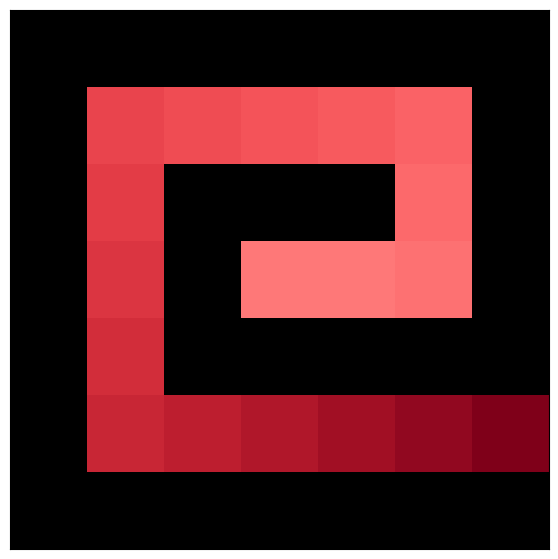

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

class MazeGame:
    def __init__(self):
        maze_layout = [
            [1, 1, 1, 1, 1, 1, 1],
            [1, 0, 0, 0, 0, 0, 1],
            [1, 0, 1, 1, 1, 0, 1],
            [1, 0, 1, 0, 0, 0, 1],
            [1, 0, 1, 1, 1, 1, 1],
            [1, 0, 0, 0, 0, 0, 0],
            [1, 1, 1, 1, 1, 1, 1]
        ]
        self.layout = np.array(maze_layout)
        self.rgb_maze = self._to_rgb()
        self.start_pos = None
        self.exit_pos = None
        self.current_pos = None

    def _to_rgb(self):
        rgba = np.ones((*self.layout.shape, 4))
        for i in range(3):  # Set RGB based on the layout
            rgba[:, :, i] *= 1 - self.layout
        rgba[:, :, 3] = 1  # Set alpha transparency fully opaque (1.0)
        return rgba

    def set_point(self, row, col, color, alpha=1.0):
        self.rgb_maze[row, col] = [*color, alpha]

    def initial_position(self, row, col):
        if self.layout[row, col] == 0:
            self.start_pos = (row, col)
            self.current_pos = (row, col)
            self.set_point(row, col, [0, 0, 1], 1)  # Mark initial position with blue
        else:
            print("Invalid initial position: It is on a wall.")

    def set_exit(self, row, col):
        if self.layout[row, col] == 0:
            self.exit_pos = (row, col)
            self.set_point(row, col, [0, 1, 0], 1)  # Mark exit position with green
        else:
            print("Invalid exit position: It is on a wall.")

    def find_path(self):
        queue = deque([(self.exit_pos, 0)])
        visited = set([self.exit_pos])
        path = {}
        while queue:
            (current, depth), queue = queue.popleft(), queue
            for direction in [(0, 1), (1, 0), (0, -1), (-1, 0)]:
                neighbor = (current[0] + direction[0], current[1] + direction[1])
                if neighbor in visited or not self.is_valid_move(neighbor):
                    continue
                queue.append((neighbor, depth + 1))
                visited.add(neighbor)
                path[neighbor] = (current, depth + 1)
                if neighbor == self.start_pos:
                    return path, depth + 1
        return path, None

    def apply_gradient(self):
        path, max_depth = self.find_path()
        if max_depth is None:
            return

        position = self.start_pos
        while position != self.exit_pos:
            prev_position, depth = path[position]
            red_intensity = 0.5 + 0.5 * (1 - (depth / max_depth) ** 2)
            blue_intensity = 0.1 * (depth / max_depth)
            alpha_value = 0.5 + 0.5 * (depth / max_depth)

            self.set_point(*position, [red_intensity, 0, blue_intensity], alpha_value)
            position = prev_position

        self.set_point(*self.exit_pos, [red_intensity, 0, blue_intensity], alpha_value)

    def is_valid_move(self, pos):
        row, col = pos
        if 0 <= row < self.layout.shape[0] and 0 <= col < self.layout.shape[1]:
            return self.layout[row, col] == 0
        return False

    def plot(self):
        plt.figure(figsize=(7, 7))
        plt.imshow(self.rgb_maze, interpolation='nearest')
        plt.xticks([]), plt.yticks([])  # Hide axes ticks
        plt.show()

# Example usage
game = MazeGame()
game.initial_position(5, 6)  # Set initial position
game.set_exit(3, 3)          # Set exit position
game.apply_gradient()        # Apply the gradient from the exit to the initial position
game.plot()                  # Display the maze with the gradient path
